# Установка зависимостей

In [ ]:
%pip install kagglehub
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install sklearn

# Импорт библиотек

In [2]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

import warnings
warnings.simplefilter("ignore", FutureWarning)
%matplotlib inline

# Вспомогательная функция для печати метрик

In [3]:
def printer(name, model, x_train_scaled, x_test_scaled, y_train, y_test):
    print("===== " + name + " =====\n")

    x_train_scaled_predicted = model.predict(x_train_scaled)
    x_test_scaled_predicted = model.predict(x_test_scaled)

    print("Точность (Train):           ", accuracy_score(y_train, x_train_scaled_predicted))
    print("Точность (Test):            ", accuracy_score(y_test, x_test_scaled_predicted))
    print()

    print("Точность (Train Precision): ", precision_score(y_train, x_train_scaled_predicted))
    print("Точность (Test Precision):  ", precision_score(y_test, x_test_scaled_predicted))
    print()

    print("Полнота (Train Recall):     ", recall_score(y_train, x_train_scaled_predicted))
    print("Полнота (Test Recall):      ", recall_score(y_test, x_test_scaled_predicted))
    print()

    print("F1-метрика (Train):         ", f1_score(y_train, x_train_scaled_predicted))
    print("F1-метрика (Test):          ", f1_score(y_test, x_test_scaled_predicted))
    print()

    print("Матрица ошибок (Train):")
    disp = ConfusionMatrixDisplay(confusion_matrix(y_train, x_train_scaled_predicted))
    disp.plot()
    plt.show()

    print("Матрица ошибок (Test):")
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, x_test_scaled_predicted))
    disp.plot()
    plt.show()

# Загрузка и подготовка данных

In [4]:
path = kagglehub.dataset_download("aadarshvelu/heart-failure-prediction-clinical-records")
print("Путь к файлам датасета:", path)

Путь к файлам датасета: C:\Users\alegu\.cache\kagglehub\datasets\aadarshvelu\heart-failure-prediction-clinical-records\versions\1


In [5]:
df = pd.read_csv("C:\\python\\GitHub Projects\\Heart-failure-prediction project\\heart_failure_clinical_records.csv")

In [6]:
x = df.drop(columns=["DEATH_EVENT"], axis=1)
y = df["DEATH_EVENT"]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Логистическая регрессия

===== Логистическая регрессия =====

Точность (Train):            0.8505
Точность (Test):             0.851

Точность (Train Precision):  0.7940140845070423
Точность (Test Precision):   0.7628865979381443

Полнота (Train Recall):      0.7124802527646129
Полнота (Test Recall):       0.7350993377483444

F1-метрика (Train):          0.7510407993338885
F1-метрика (Test):           0.7487352445193929

Матрица ошибок (Train):


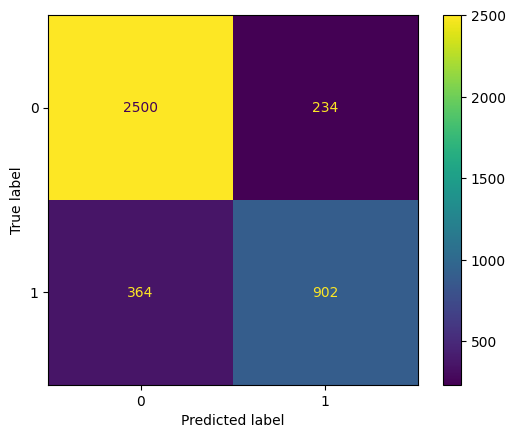

Матрица ошибок (Test):


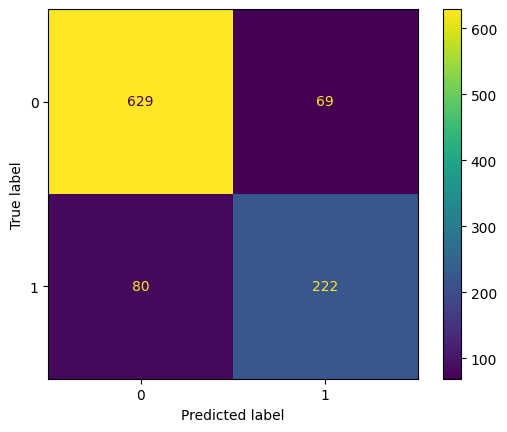

In [8]:
lr = LogisticRegression().fit(x_train_scaled, y_train)
printer("Логистическая регрессия", lr, x_train_scaled, x_test_scaled, y_train, y_test)

# Случайный лес

===== Случайный лес =====

Точность (Train):            0.9995
Точность (Test):             0.992

Точность (Train Precision):  1.0
Точность (Test Precision):   0.9867549668874173

Полнота (Train Recall):      0.9984202211690363
Полнота (Test Recall):       0.9867549668874173

F1-метрика (Train):          0.9992094861660079
F1-метрика (Test):           0.9867549668874173

Матрица ошибок (Train):


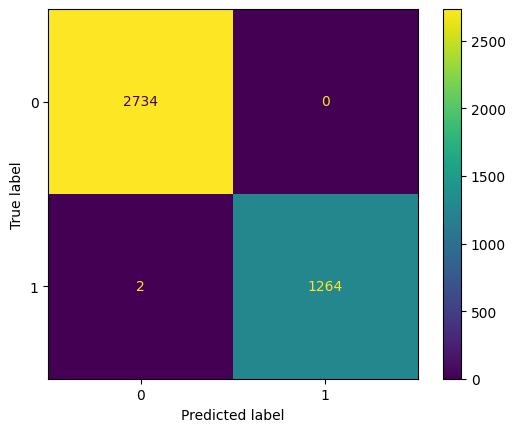

Матрица ошибок (Test):


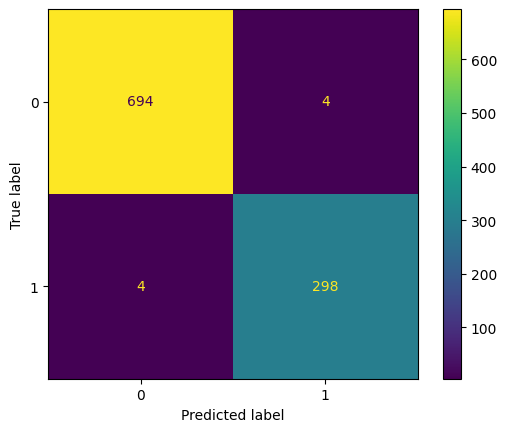

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(x_train_scaled, y_train)
printer("Случайный лес", rf, x_train_scaled, x_test_scaled, y_train, y_test)

# Метод ближайших соседей

===== K-ближайших соседей =====

Точность (Train):            0.97975
Точность (Test):             0.979

Точность (Train Precision):  0.9836734693877551
Точность (Test Precision):   0.9636963696369637

Полнота (Train Recall):      0.9518167456556083
Полнота (Test Recall):       0.9668874172185431

F1-метрика (Train):          0.967482938578884
F1-метрика (Test):           0.9652892561983472

Матрица ошибок (Train):


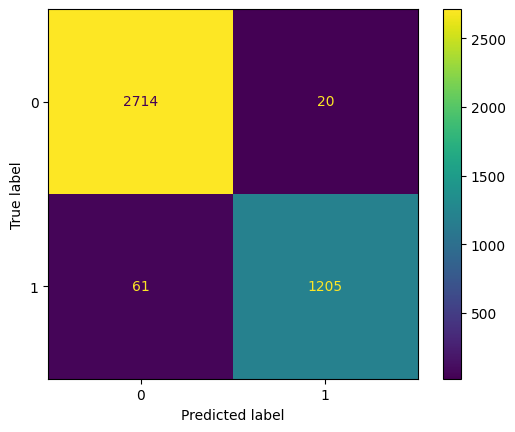

Матрица ошибок (Test):


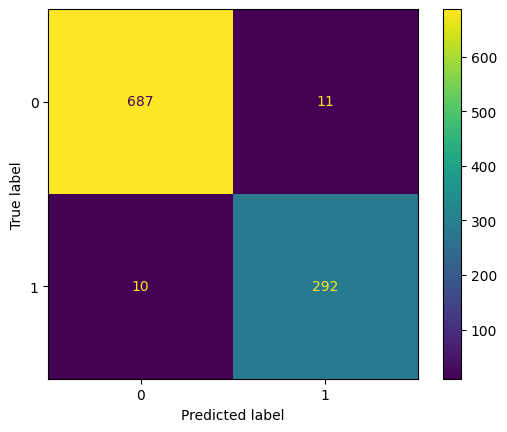

In [10]:
kn = KNeighborsClassifier().fit(x_train_scaled, y_train)
printer("K-ближайших соседей", kn, x_train_scaled, x_test_scaled, y_train, y_test)

# XGBoost

===== XGBoost =====

Точность (Train):            0.9995
Точность (Test):             0.992

Точность (Train Precision):  1.0
Точность (Test Precision):   0.9835526315789473

Полнота (Train Recall):      0.9984202211690363
Полнота (Test Recall):       0.9900662251655629

F1-метрика (Train):          0.9992094861660079
F1-метрика (Test):           0.9867986798679867

Матрица ошибок (Train):


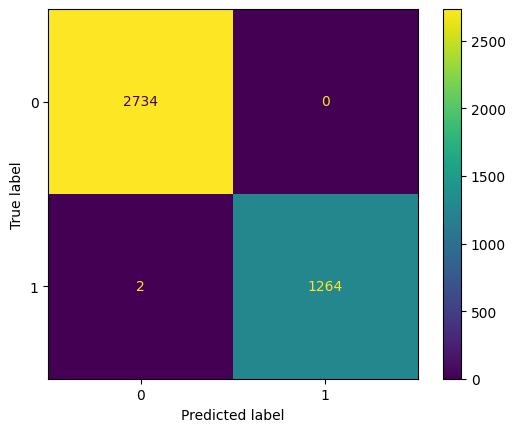

Матрица ошибок (Test):


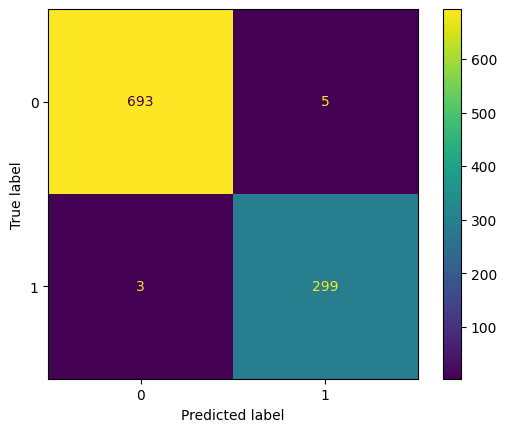

In [11]:
xgb = XGBClassifier().fit(x_train_scaled, y_train)
printer("XGBoost", xgb, x_train_scaled, x_test_scaled, y_train, y_test)

# Сравнение моделей (кросс-валидация)

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_scores = cross_val_score(lr, x_train_scaled, y_train, cv=skf, scoring='f1')
rf_scores = cross_val_score(rf, x_train_scaled, y_train, cv=skf, scoring='f1')
kn_scores = cross_val_score(kn, x_train_scaled, y_train, cv=skf, scoring='f1')
xgb_score = cross_val_score(xgb, x_train_scaled, y_train, cv=skf, scoring='f1')

In [13]:
print("Логистическая регрессия: %0.4f ± %0.4f" % (lr_scores.mean(), lr_scores.std()))
print("Случайный лес:           %0.4f ± %0.4f" % (rf_scores.mean(), rf_scores.std()))
print("Метод соседей:           %0.4f ± %0.4f" % (kn_scores.mean(), kn_scores.std()))
print("XGBoost:                 %0.4f ± %0.4f" % (xgb_score.mean(), xgb_score.std()))

Логистическая регрессия: 0.7432 ± 0.0132
Случайный лес:           0.9869 ± 0.0041
Метод соседей:           0.9537 ± 0.0094
XGBoost:                 0.9873 ± 0.0031


# Boxplot сравнение моделей по F1-метрике

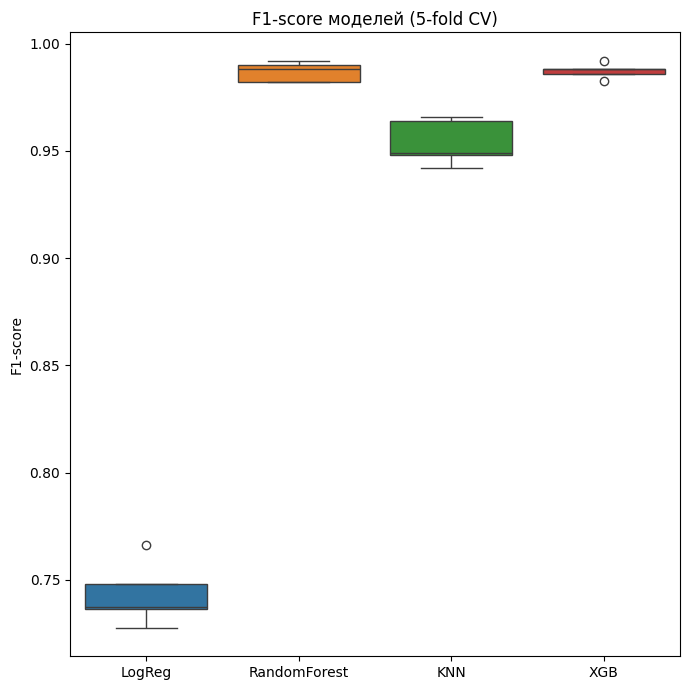

In [14]:
plt.figure(figsize=(7, 7))
sns.boxplot(data=[lr_scores, rf_scores, kn_scores, xgb_score])
plt.xticks([0, 1, 2, 3], ["LogReg", "RandomForest", "KNN", "XGB"])
plt.ylabel("F1-score")
plt.title("F1-score моделей (5-fold CV)")
plt.tight_layout()
plt.show()

# Подбор гиперпараметров (GridSearchCV)

In [15]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

param_grid = [
    {
        'clf': [LogisticRegression()], 
        'clf__C': [0.1, 1, 10]
    },
    {
        'clf': [RandomForestClassifier(random_state=42)], 
        'clf__n_estimators': [50, 100, 200], 
        'clf__max_depth': [None, 5, 10]
    },
    {
        'clf': [KNeighborsClassifier()], 
        'clf__n_neighbors': [5, 10, 15]
    },
    {
        'clf': [XGBClassifier()], 
        'clf__n_estimators': [100, 200], 
        'clf__max_depth': [3, 5, 7], 
        'clf__learning_rate': [0.01, 0.1]
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')
grid.fit(x_train_scaled, y_train)

results = pd.DataFrame(grid.cv_results_)
cols = ['param_clf', 'mean_test_score', 'std_test_score', 'params']
print(results[cols].sort_values('mean_test_score', ascending=False))

                                            param_clf  mean_test_score  \
24  XGBClassifier(base_score=None, booster=None, c...         0.988854   
26  XGBClassifier(base_score=None, booster=None, c...         0.988054   
23  XGBClassifier(base_score=None, booster=None, c...         0.987260   
5             RandomForestClassifier(random_state=42)         0.987238   
4             RandomForestClassifier(random_state=42)         0.986821   
10            RandomForestClassifier(random_state=42)         0.986416   
3             RandomForestClassifier(random_state=42)         0.986026   
11            RandomForestClassifier(random_state=42)         0.986012   
9             RandomForestClassifier(random_state=42)         0.986012   
25  XGBClassifier(base_score=None, booster=None, c...         0.985659   
22  XGBClassifier(base_score=None, booster=None, c...         0.980917   
20  XGBClassifier(base_score=None, booster=None, c...         0.976374   
19  XGBClassifier(base_score=None, boo

# ROC-кривые и AUC для лучших моделей

XGB AUC:           0.9994259853128142
Random Forest AUC: 0.9997983832710298


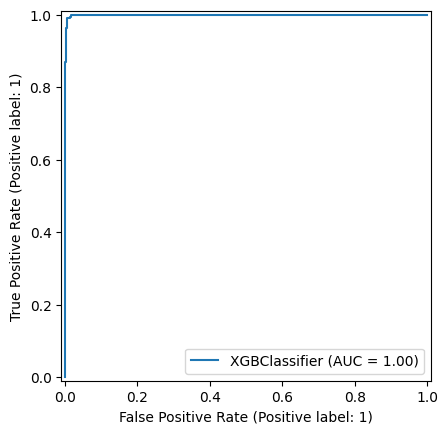

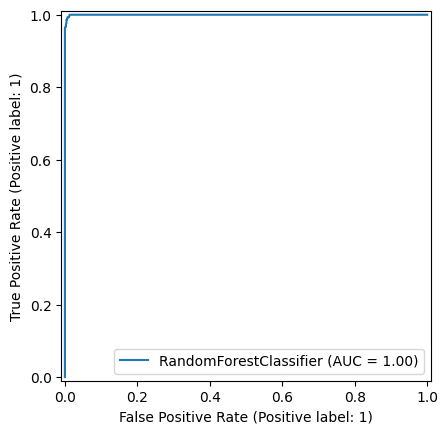

In [16]:
RocCurveDisplay.from_estimator(xgb, x_test_scaled, y_test)
RocCurveDisplay.from_estimator(rf, x_test_scaled, y_test)

y_pred_xgb = xgb.predict_proba(x_test_scaled)[:, 1]
y_pred_rf = rf.predict_proba(x_test_scaled)[:, 1]

print("XGB AUC:          ", roc_auc_score(y_test, y_pred_xgb))
print("Random Forest AUC:", roc_auc_score(y_test, y_pred_rf))

# Важность признаков

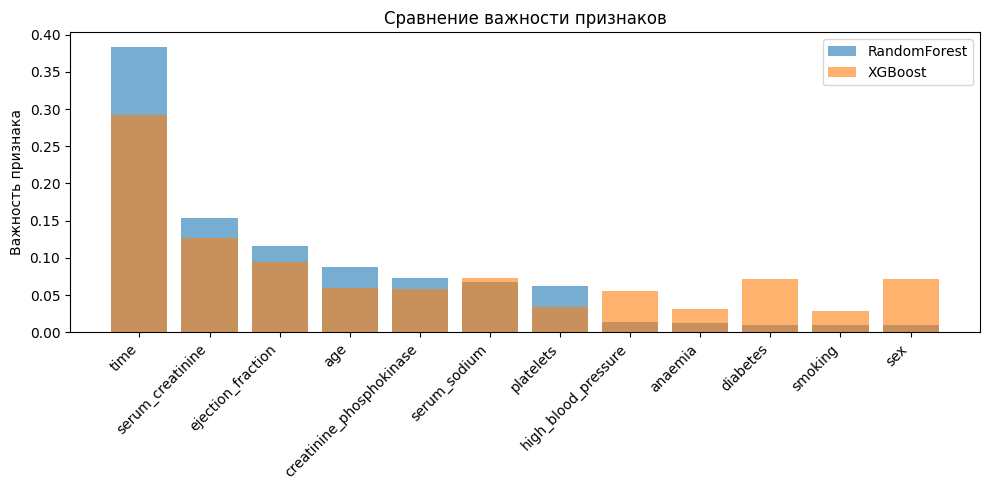

In [17]:
dt_val_rf = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)
dt_val_xgb = pd.Series(xgb.feature_importances_, index=x.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(dt_val_rf.index, dt_val_rf.values, alpha=0.6, label='RandomForest')
plt.bar(dt_val_xgb.index, dt_val_xgb.values, alpha=0.6, label='XGBoost')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Важность признака')
plt.title('Сравнение важности признаков')
plt.legend()
plt.tight_layout()
plt.show()

# Вывод

Модель **XGBoost** показала себя лучше, чем Random Forest. Несмотря на близкие значения AUC, у XGB более компактное распределение F1-оценок и лучшие результаты перекрёстной проверки.

F1-score XGB: **0.9873 ± 0.0031**

F1-score Random Forest: **0.9869 ± 0.0041**

Как и ожидалось, наибольшее влияние на предсказание оказывает параметр **time of monitoring (в днях)**.